# Grad-CAM

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import pretrainedmodels

from utils import load_image, preprocess_image, load_class_idx
from modify_models import modify_model

%matplotlib inline

In [2]:
model = pretrainedmodels.vgg16(num_classes=1000);

In [3]:
class GradCAM:
    def __init__(self, model):
        self.model = model
        self.outputs = None
        self.gradients = None
        self.predictions = None
        self.feature_maps = None
        self.idx2label = load_class_idx()
        self.input_size = self.model.input_size[1:]
        
        self.model.eval()
    
    def _save_gradients(self, grad):
        self.gradients = grad.detach().numpy()[0]
    
    def _forward_pass(self, img, use_logits):
        feature_maps = self.model.features(img)
        logits = self.model.logits(feature_maps)
        probas = F.softmax(logits, dim=-1)
        
        feature_maps.register_hook(self._save_gradients)
        
        if use_logits:
            self.outputs = logits
        else:
            self.outputs = probas
        
        self.predictions = probas.detach().numpy().squeeze()  # (n_classes,)
        self.feature_maps = feature_maps.detach().numpy().squeeze()  # (c, h, w)
        
    def _backward_pass(self, class_idx):    
        onehot_target = torch.zeros(self.predictions.shape, dtype=torch.float)  # (n_classes,)
        onehot_target = torch.unsqueeze(onehot_target, dim=0)  # (1, n_classes)
        onehot_target[0][class_idx] = 1
        
        self.model.zero_grad()
        self.outputs.backward(gradient=onehot_target)
        
    def _get_class_idx(self, i):
        class_idx = self.predictions.argsort()
        class_idx = class_idx[-i]
        
        return class_idx
    
    def generate_heatmap(self, img, class_idx,
                         counterfactual=False,
                         relu_on_gradients=False,
                         use_logits=True):
        if isinstance(img, Image.Image):
            img = preprocess_image(img)
        
        self._forward_pass(img, use_logits)
        self._backward_pass(class_idx)
        
        if relu_on_gradients:
            weights = np.mean(np.maximum(self.gradients, 0), axis=(1, 2))
        else:
            weights = np.mean(self.gradients, axis=(1, 2))
        weights = weights.reshape((-1, 1, 1))
        
#         print(weights.min())
#         print(weights.max())
        
        if counterfactual:
            weights = - weights
        
        heatmap = np.sum(weights * self.feature_maps, axis=0)  # weighted sum over feature maps
        heatmap = np.maximum(heatmap, 0)  # ReLU
        heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))  # Normalize between 0-1
        heatmap = np.uint8(heatmap * 255)
        heatmap = Image.fromarray(heatmap)
        heatmap = heatmap.resize(self.input_size, Image.ANTIALIAS)
        heatmap = np.array(heatmap)
        
        return heatmap
        
    def plot_image_heatmap(self, img_path, top=1,
                           counterfactual=False,
                           relu_on_gradients=False,
                           use_logits=True,
                           save_path=None):
        img = load_image(img_path, size=self.input_size)
        img_tensor = preprocess_image(img)
        
        self._forward_pass(img_tensor, use_logits)
        
        plt.imshow(img)
        plt.axis('off')
        
        cols = top + 1
        plt.figure(figsize=(4 * cols, 4))
        for i in range(cols):
            if i == 0:
                plt.subplot(1, cols, i+1)
                plt.imshow(img, alpha=1.0)
                plt.title('original image')
                plt.axis('off')
            else:
                class_idx = self._get_class_idx(i)
                label = self.idx2label[class_idx]
                proba = self.predictions[class_idx]
                heatmap = self.generate_heatmap(img_tensor, class_idx, counterfactual, relu_on_gradients, use_logits)
                
                plt.subplot(1, cols, i+1)
                plt.imshow(img, alpha=1.0)
                plt.imshow(heatmap, cmap='rainbow', alpha=0.7)
                plt.title('{} ({:.3f})'.format(label, proba))
                plt.axis('off')
                
        if save_path:
            plt.savefig(save_path)

In [4]:
img = load_image('../images/cat_dog.png', size=model.input_size[1:])
img.size

(224, 224)

In [5]:
model = modify_model(model)

In [6]:
grad_cam = GradCAM(model)

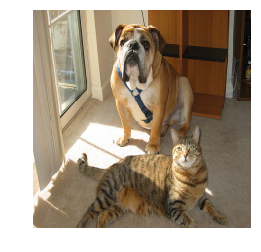

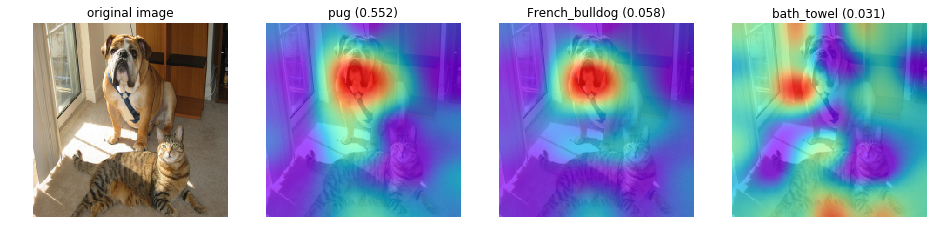

In [7]:
grad_cam.plot_image_heatmap('../images/cat_dog.png', top=3, relu_on_gradients=False, use_logits=True)

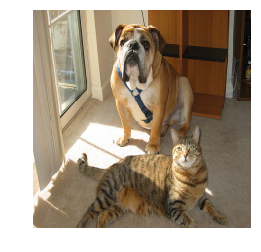

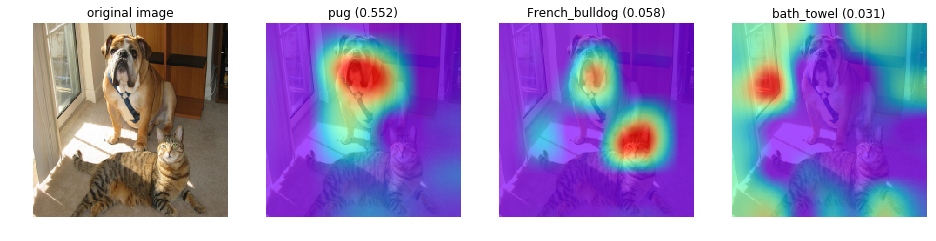

In [8]:
grad_cam.plot_image_heatmap('../images/cat_dog.png', top=3, relu_on_gradients=False, use_logits=False)

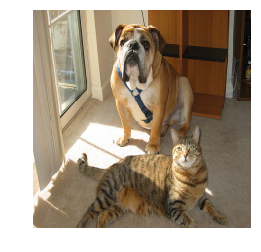

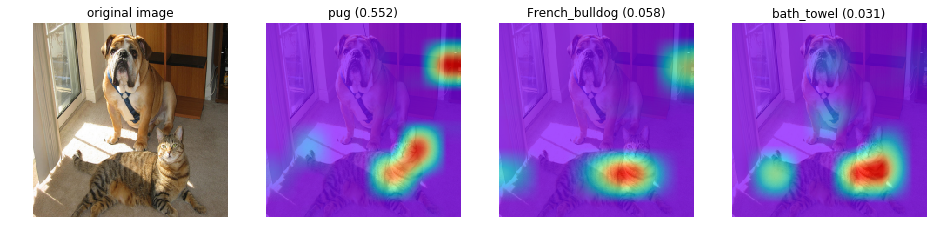

In [9]:
grad_cam.plot_image_heatmap('../images/cat_dog.png', top=3, counterfactual=True, use_logits=True)

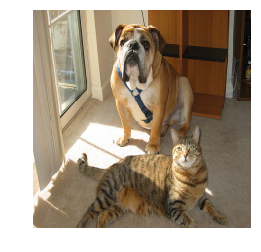

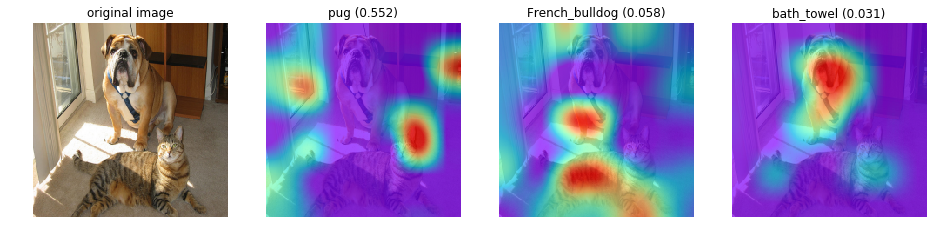

In [10]:
grad_cam.plot_image_heatmap('../images/cat_dog.png', top=3, counterfactual=True, use_logits=False)

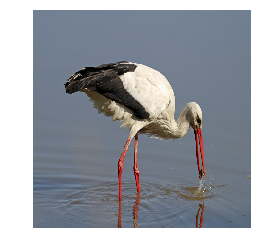

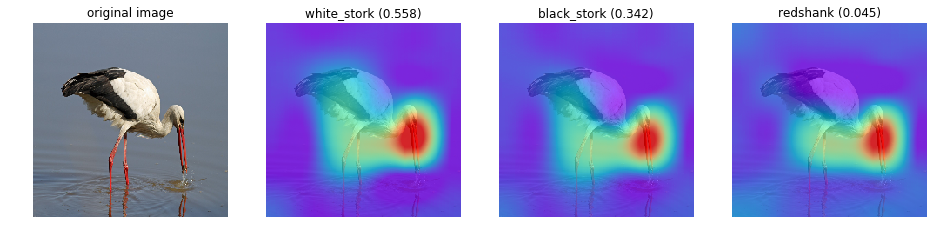

In [11]:
grad_cam.plot_image_heatmap('../images/white stork.jpg', top=3, counterfactual=False, use_logits=True)

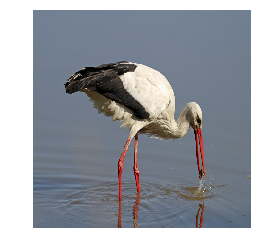

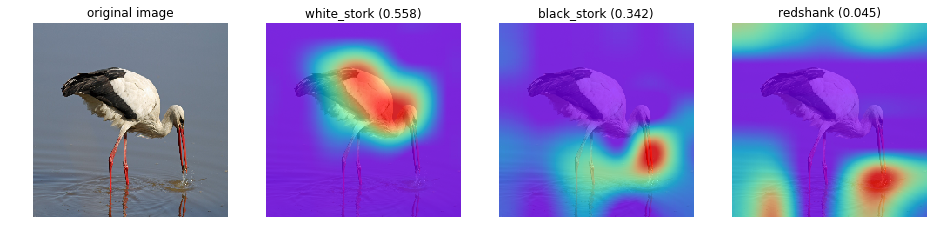

In [12]:
grad_cam.plot_image_heatmap('../images/white stork.jpg', top=3, counterfactual=False, use_logits=False)

/Users/william/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


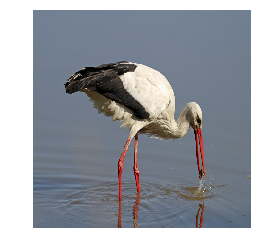

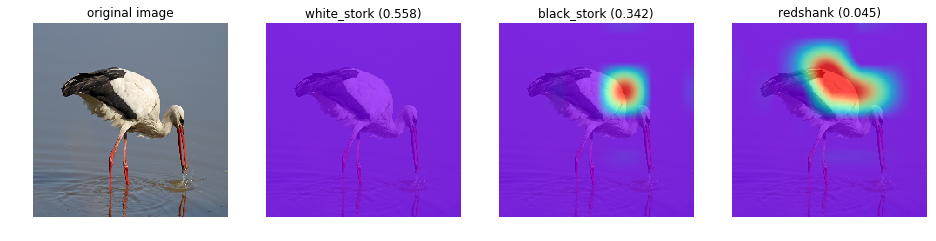

In [13]:
grad_cam.plot_image_heatmap('../images/white stork.jpg', top=3, counterfactual=True, use_logits=True)

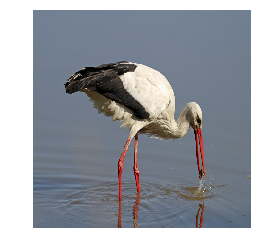

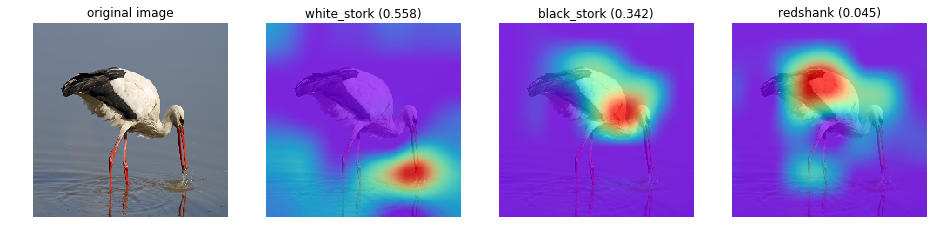

In [14]:
grad_cam.plot_image_heatmap('../images/white stork.jpg', top=3, counterfactual=True, use_logits=False)